In [141]:
from torch import nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

In [235]:
def encoder(C_in, C_out, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(C_in, C_out, kernel_size, stride, padding),
        nn.ReLU(),
        nn.Conv2d(C_out, C_out, kernel_size, stride, padding),
        nn.ReLU(),
    )

def decoder(C_in, C_out, kernel_size, stride=1, padding=0, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(C_in, C_out, kernel_size, stride, padding, output_padding),
        nn.ReLU(),
        nn.ConvTranspose2d(C_out, C_out, kernel_size, stride, padding, output_padding),
        nn.ReLU(),
    )

class U_net_01(nn.Module):
    """A first attempt to reduce dimensionality of the cell
    """

    def __init__(self):
        super().__init__()
        # C_in, C_out, kernel_size, stride=1, padding=0, output_padding=0
        self.enc1 = encoder(1, 9, 3)
        self.enc2 = encoder(9, 9, 3, 2, 2)
        self.enc3 = encoder(9, 9, 3)

        self.dec3 = decoder(9, 9, 2)
        self.dec2 = decoder(9, 9, 2, 2, 2, output_padding=1)
        self.dec1 = decoder(9, 1, 2)
        self.layers = [self.enc1, self.enc2, self.enc3, self.dec3, self.dec2, self.dec1]
        # self.layers = nn.Sequential([
        #     nn.Conv2d(1, 3, 3), nn.LeakyReLU(), 
        #     nn.Conv2d(3, 9, 9, 2), nn.LeakyReLU(), 
        #     nn.Conv2d(9, 81, 9), nn.LeakyReLU(),

        #     nn.ConvTranspose2d(81, 9, 9), nn.LeakyReLU(),
        #     nn.ConvTranspose2d(9, 3, 9, 2, output_padding=1),  nn.LeakyReLU(),
        #     nn.ConvTranspose2d(3, 1, 3),  nn.LeakyReLU(),
        # ])

    def forward(self, x):
        for layer in self.layers:
           x = layer(x)
           print(layer, x.shape)
        return x


    # def forward(self, input_tensor):
    #     indcs = []
    #     x = input_tensor
    #     first = True
    #     for layer in self.layers:
    #         if type(layer) == nn.MaxPool2d:
    #             x, idx = layer.forward(x)
    #             indcs.append(idx)
    #         elif type(layer) == nn.MaxUnpool2d:
    #             print(x.shape, indcs[0].shape)
    #             x = layer.forward(x, indcs.pop())
    #         else:
    #             x = layer.forward(x)
    #     return x

In [236]:
model = U_net_01()
A = np.zeros([1,1,100,100]).astype(np.float32)
A[0,0,20:40,20:40] = 1
plt.imshow(A[0,0]); plt.show()
tt = torch.tensor(A)
model.forward(tt)

TypeError: encoder() missing 2 required positional arguments: 'stride' and 'padding'

In [232]:
from tqdm import trange
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()

losses = []
for i in range(100):
    optimizer.zero_grad()
    out = model.forward(tt)
    loss_ = loss(out, tt)
    loss_.backward()
    optimizer.step()
    losses.append(loss_.detach().numpy())
    if i % 10 == 0:
        plt.imshow(out.detach().numpy()[0,0])
        plt.show()

plt.plot(losses)

Sequential(
  (0): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
) torch.Size([1, 9, 100, 100])
Sequential(
  (0): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (3): ReLU()
) torch.Size([1, 9, 27, 27])
Sequential(
  (0): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(9, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
) torch.Size([1, 9, 27, 27])
Sequential(
  (0): ConvTranspose2d(9, 9, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(9, 9, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
) torch.Size([1, 9, 25, 25])


RuntimeError: output padding must be smaller than either stride or dilation, but got output_padding_height: 2 output_padding_width: 2 stride_height: 2 stride_width: 2 dilation_height: 1 dilation_width: 1

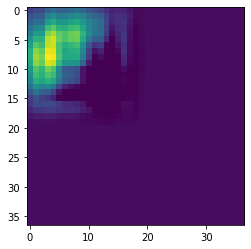

In [197]:
x = copy(tt)
for layer in model.layers:
    if type(layer) != torch.nn.modules.conv.ConvTranspose2d:
        x = layer.forward(x)
    else:
        break

plt.imshow(x[0,0].detach().numpy())

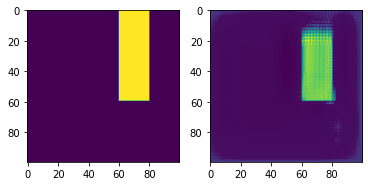

In [198]:
B = np.zeros_like(A)
B[0,0, 0:60, 60:80] = 1
t = torch.tensor(B)
out = model.forward(t).detach().numpy()
fig, ax = plt.subplots(1,2)
ax[0].imshow(B[0,0])
ax[1].imshow(out[0,0])

(3, 1, 3, 3)


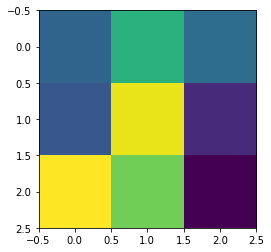

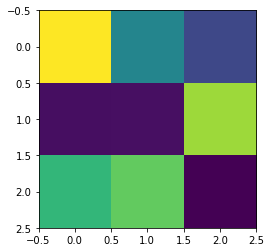

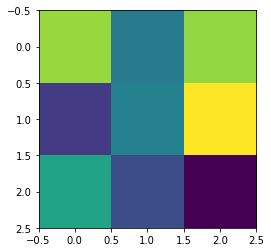

In [186]:
weights = model.layers[-2].weight.detach().numpy()
print(weights.shape)
for i in range(weights.shape[0]):
    plt.imshow(weights[i,0,:,:])
    plt.show()